# Clustering

### Setup data

In [13]:
from db.connection import get_connection
import pandas as pd

query = f"""
    SELECT 
    a.report_id, 
    a.occurred, 
    b.embedding, 
    c.latitude, 
    c.longitude
    FROM 
    ufo_reports_transform a
    JOIN 
    description_averaged_embeddings b
    ON a.report_id = b.report_id
    JOIN 
    city_county_lat_lon c
    ON 
        TRIM(SPLIT_PART(a.location, ',', 1)) = TRIM(c.city) AND 
        TRIM(SPLIT_PART(a.location, ',', 2)) = TRIM(c.state)
    WHERE occurred is not null
    ;
    """

conn = get_connection()
    
try:
    df = pd.read_sql(query, conn)
except Exception as e:
    print(f"Error executing query: {e}")
    df = None
finally:
    conn.close()


print(df.head)

2024-11-22 23:45:48,268 [INFO] db.connection: Database connection established.


/var/folders/b6/5kj2tkgn6vx8kxcyhfg6pf9c0000gn/T/ipykernel_17005/3839161389.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


<bound method NDFrame.head of        report_id    occurred  \
0        S161267  1606962600   
1        S144647  1548320400   
2         S98221  1369822500   
3         S41177   337932000   
4         S33851   337924800   
...          ...         ...   
105018    S33854   911212200   
105019    S04856   911098800   
105020    S31927   911199600   
105021    S17595   910949400   
105022    S22111   911192400   

                                                embedding   latitude  \
0       [0.016444052,0.06212723,0.049611054,0.07362398...  40.837518   
1       [0.033369765,-0.022478051,0.020196505,0.001629...  38.802758   
2       [0.04027589,-0.015154102,0.007161611,0.0472713...  33.908275   
3       [0.028260397,0.04181325,0.024015397,0.04231337...  41.180778   
4       [0.04406667,0.040626522,0.0037232835,0.0134104...  44.225891   
...                                                   ...        ...   
105018  [0.016414233,0.04707198,0.017670805,0.04804515...  40.180190   
105019  [

### DBSCAN

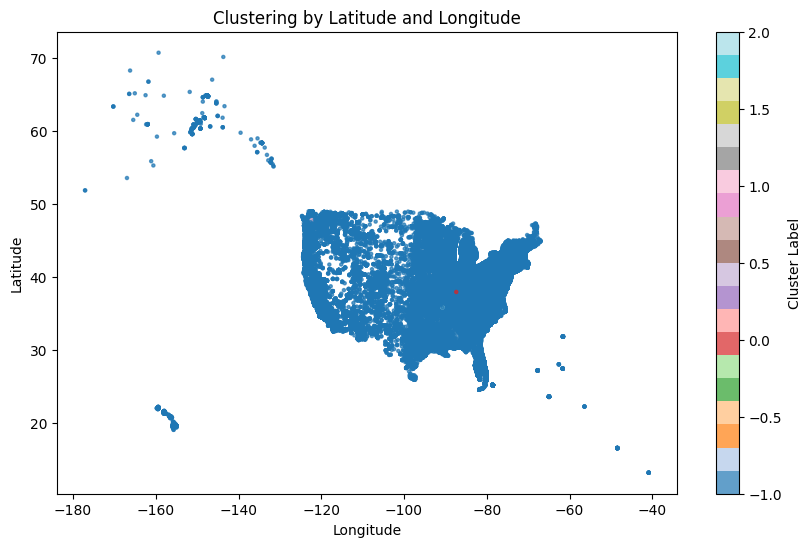

In [14]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def prepare_clustering_data(df):
    embedding_array = np.stack(df['embedding'].apply(eval).to_numpy())
    occurred = df['occurred'].values.reshape(-1, 1)
    lat_lon = df[['latitude', 'longitude']].values
    combined_features = np.hstack([occurred, embedding_array, lat_lon])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(combined_features)
    return scaled_features

def cluster_with_dbscan(data, eps=0.5, min_samples=10):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    cluster_labels = dbscan.fit_predict(data)
    return cluster_labels

def visualize_clusters(df, cluster_labels):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df['longitude'], 
        df['latitude'], 
        c=cluster_labels, 
        cmap='tab20', 
        alpha=0.7, 
        s=5
    )
    plt.colorbar(scatter, label="Cluster Label")
    plt.title("Clustering by Latitude and Longitude")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


scaled_features = prepare_clustering_data(df)

cluster_labels = cluster_with_dbscan(scaled_features, eps=2.0, min_samples=50)

df['cluster'] = cluster_labels

visualize_clusters(df, cluster_labels)


In [12]:
print("DataFrame columns:", df.columns)

# Optionally print the first few rows
print(df.head())

DataFrame columns: Index(['rid', 'occ', 'emb', 'lat', 'long'], dtype='object')
       rid         occ                                                emb  \
0  S161267  1606962600  [0.016444052,0.06212723,0.049611054,0.07362398...   
1  S144647  1548320400  [0.033369765,-0.022478051,0.020196505,0.001629...   
2   S98221  1369822500  [0.04027589,-0.015154102,0.007161611,0.0472713...   
3   S41177   337932000  [0.028260397,0.04181325,0.024015397,0.04231337...   
4   S33851   337924800  [0.04406667,0.040626522,0.0037232835,0.0134104...   

         lat        long  
0  40.837518  -75.693556  
1  38.802758  -91.246612  
2  33.908275 -118.011311  
3  41.180778  -73.190495  
4  44.225891  -68.299710  
